In [45]:
import numpy as np
from IPython.display import HTML
from matplotlib import pyplot as plt
from tqdm import notebook
from itertools import combinations
import scipy as sp
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter 
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 선형대수로 열 방정식 풀기 2 dimension
- 이제 2차원을 풀어보자. 
- xy 평면(Cartesian grid)에 해서 계산하자. $t,x,y$ 모두 $N$개의 구간으로 나누면 solution $U(t,x,y)=U_{n,i,j}$는 $N\times N\times N$ tensor가 된다. 거기에 경계조건, 초기조건을 고려하면 $(N+1)\times (N+2)\times (N+2)$가 된다.
- 1차원에서 했던 것처럼 Crank-Nicolson mothod를 적용하면 다음과 같다.
\begin{align}
\partial_t u &= \frac{u_{n+1,i,j}-u_{n,i,j}}{h'}, \\
\partial_x^2 u &= \frac{1}{2}
\biggl(
\frac{u_{n+1,i+1,j}-2u_{n+1,i,j}+u_{n+1,i-1,j}}{h^2} + \frac{u_{n,i+1,j}-2u_{n,i,j}+u_{n,i-1,j}}{h^2}
\biggr), \\
\partial_y^2 u &= \frac{1}{2}
\biggl(
\frac{u_{n+1,i,j+1}-2u_{n+1,i,j}+u_{n+1,i,j-1}}{h^2} + \frac{u_{n,i,j+1}-2u_{n,i,j}+u_{n,i,j-1}}{h^2}
\biggr)
\end{align}
따라서
\begin{align}
u_{n+1,i,j}-u_{n,i,j} &=
\frac{\alpha h'}{2h^2} \biggl(
u_{n+1,i+1,j}+u_{n+1,i-1,j}+u_{n+1,i,j+1}+u_{n+1,i,j-1}-4u_{n+1,i,j} + \\
& u_{n,i+1,j}+u_{n,i-1,j}+u_{n,i,j+1}+u_{n,i,j-1}-4u_{n+1,i,j}
\biggr)
\end{align}
- 그런데 1차원과는 다르게 이 방법은 비효율적인 것으로 알려져있다([링크](https://en.wikipedia.org/wiki/Crank%E2%80%93Nicolson_method#Example:_2D_diffusion))

- 다른 방법으로는 [ADI method](https://en.wikipedia.org/wiki/Alternating-direction_implicit_method#ADI_for_parabolic_equations)(Alternating-Direction Implicit method)
- 요지는 다음과 같다. Crank-Nicolson mothod처럼 $t_{n+1/2}$을 central하게 나누되, $n$번 째에 x에 대해서 계산하고, $n+1/2$째는 y, 다시 $n$번 째는 x에 대해 계산하는 것을 반복한다. 좌변은 다음과 같다.
$$
\frac{u_{n+1,i,j}-u_{n,i,j}}{h'} = \frac{(u_{n+1/2,i,j}-u_{n,i,j})+(u_{n+1,i,j}-u_{n+1/2,i,j})}{h'}
$$
우변은(조금 복잡함, 상수 생략) 다음과 같다.
\begin{align}
\biggl( 
&(u_{n+1,i+1,j}+u_{n+1,i-1,j}-2u_{n+1,i,j}) + (u_{n+1,i,j+1}+u_{n+1,i,j-1}-2u_{n+1,i,j})+\\
& (u_{n,i+1,j}+u_{n,i-1,j}-2u_{n,i,j}) + (u_{n,i,j+1}+u_{n,i,j-1}-2u_{n,i,j}) \biggr) \\
= \biggl( &(u_{n+1,i+1,j}+u_{n+1,i-1,j}-2u_{n+1,i,j}) + (u_{n+1/2,i,j+1}+u_{n+1/2,i,j-1}-2u_{n+1/2,i,j})+\\
& (u_{n+1/2,i+1,j}+u_{n+1/2,i-1,j}-2u_{n+1/2,i,j}) + (u_{n,i,j+1}+u_{n,i,j-1}-2u_{n,i,j})
\biggr) 
\end{align}
따라서 다음과 같이 두 방정식을 얻는다.
\begin{align}
\frac{(u_{n+1/2,i,j}-u_{n,i,j})}{h'} &= \frac{\alpha}{2h^2}
\biggl( (u_{n+1/2,i+1,j}+u_{n+1/2,i-1,j}-2u_{n+1/2,i,j}) + (u_{n,i,j+1}+u_{n,i,j-1}-2u_{n,i,j})
\biggr), \\
\frac{(u_{n+1,i,j}-u_{n+1/2,i,j})}{h'} &= \frac{\alpha}{2h^2}
\biggl( (u_{n+1,i,j+1}+u_{n+1,i,j-1}-2u_{n+1,i,j}) + (u_{n+1/2,i+1,j}+u_{n+1/2,i-1,j}-2u_{n+1/2,i,j})
\biggr)
\end{align}
- 연결된 Tridiagnoal equation 두개를 얻었다.

In [186]:
def tri_diag_solver(a,b,c,d):
    N = b.shape[0]
    x = np.zeros((N,))
    c_ = np.zeros((N-1,))
    d_ = np.zeros((N,))
    c_[0] = c[0] / b[0]
    d_[0] = d[0] / b[0]
    for i in np.arange(1,N-1):
        c_[i] = c[i] / (b[i]-a[i]*c_[i-1])
        d_[i] = (d[i]-a[i]*d_[i-1]) / (b[i]-a[i]*c_[i-1])
    d_[-1] = (d[-1]-a[-1]*d_[-2]) / (b[-1]-a[-1]*c_[-1])
    x[N-1] = d_[N-1]
    for i in np.arange(N-1)[::-1]:
        x[i] = d_[i] - c_[i] * x[i+1]
    return x

# def heat_eq_1d_solver(u,r):
#     u_ = u.copy()
#     N = u.shape[0] 
#     a = -r * np.ones((N-3,))
#     b = (2+2*r) * np.ones((N-2,))
#     c = -r * np.ones((N-3,))
#     d = np.zeros((N-2,))
# #     d = r * u[:N-2] + (2-2*r) * u[1:N-1] + r * u[2:]
#     for i in np.arange(N-2):
#         d[i] = r * u[i] + (2-2*r) * u[i+1] + r * u[i+2]
#     d[0] += r * u[0]
#     d[-1] += r * u[-1]
#     u_[1:N-1] = tri_diag_solver(a,b,c,d)
#     return u_

def heat_eq_1d_solver(u,r,b1,b2):
    # b1, b2: 다음 스탭의 경계값
    u_ = u.copy()
    N = u.shape[0] 
    a = -r * np.ones((N-3,))
    b = (2+2*r) * np.ones((N-2,))
    c = -r * np.ones((N-3,))
    d = np.zeros((N-2,))
#     d = r * u[:N-2] + (2-2*r) * u[1:N-1] + r * u[2:]
    for i in np.arange(N-2):
        d[i] = r * u[i] + (2-2*r) * u[i+1] + r * u[i+2]
    d[0] += r * b1
    d[-1] += r * b2
    u_[1:N-1] = tri_diag_solver(a,b,c,d)
    u_[0] = b1
    u_[-1] = b2
    return u_

def heat_eq_2d_solver(U,r,bx1,bx2,by1,by2):
    N = U.shape[0]
    U_ = U.copy()
    for n in np.arange(1,N-1):
        U_[n] = heat_eq_1d_solver(U[n],r,by1[n-1],by2[n-1])
    U__ = U_.copy()
    for n in np.arange(1,N-1):
        U__[:,n] = heat_eq_1d_solver(U_.T[n],r,bx1[n-1],bx2[n-1])
    return U__

In [199]:
alpha = 2.0
Nt = 100
Nx = 100
Ny = 100
t1 = 0
t2 = 1
x1 = 0
x2 = 10
y1 = 0
y2 = 5
T = np.linspace(t1,t2,num=Nt)
X = np.linspace(x1,x2,num=Nx)
Y = np.linspace(y1,y2,num=Ny)
ht = (t2-t1) / Nt
hx = (x2-x1) / Nx
hy = (y2-y1) / Ny
r = alpha * ht / (hx * hy)
U = np.zeros((Nt+1,Nx+2,Ny+2))
# 경계조건
U_top = 100.
U_bottom = 0
U_left = 0.
U_right = 0

U[:,:,0] = U_left
U[:,:,-1] = U_right
U[:,-1,:] = U_bottom
U[:,0,:] = U_top

bx1 = U_top * np.ones((Nt,))
bx2 = U_bottom * np.ones((Nt,))
by1 = U_left * np.ones((Nt,))
by2 = U_right * np.ones((Nt,))
# 초기조건
U[0,1:Nx+1,1:Ny+1] = 0.

In [200]:
for t in notebook.tqdm(np.arange(1,Nt+1)):
    U[t] = heat_eq_2d_solver(U[t-1],r,bx1,bx2,by1,by2)

  0%|          | 0/100 [00:00<?, ?it/s]

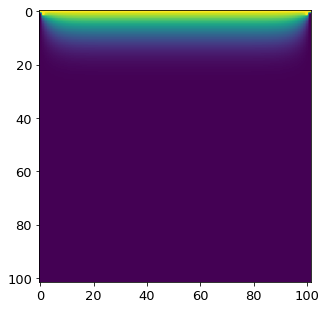

In [204]:
t = 10
plt.rcParams["figure.figsize"] = (10,5)
plt.imshow(U[t],vmin=0,vmax=100)
plt.show()

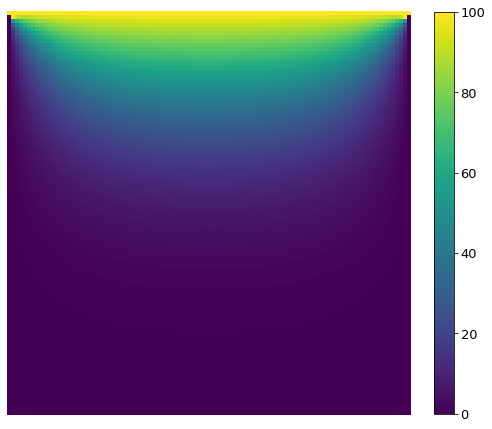

In [205]:
vmin = 0
vmax = 100
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["font.size"] = 13
fig = plt.figure()
ax = fig.add_subplot(111)
div = make_axes_locatable(ax)
cv0 = U[0]
im = ax.imshow(cv0)
ax.axis('off')
cb = fig.colorbar(im,fraction=0.045)

def animate(t):
    im.set_data(U[t])
    im.set_clim(vmin=vmin,vmax=vmax)
    
ani = animation.FuncAnimation(fig,animate,frames=Nt,interval=1,repeat = True)
ani.save("test_2t_ret.gif", writer=PillowWriter(fps=1000/fps),dpi=150)    
plt.show()

- 얼추 맞는거 같다. 제대로 확인하려면 열 방정식을 풀어야 하는데 사각형에서 해석적(analytic)해가 있는지 모르겠다. 그나마 경계가 0으로 고정되어 있을 경우에는 Fourier series로 근사할 수 있을거 같은데 이것도 또 구현해야 한다...
- 만약 사각형이 아니라면 어떻게 해야할까? 임의의 모양으로 하는 방법이 있을까? 좌표 변환(coordiante transform)을 해야하나? 감이 안온다..